In [4]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, cluster_data, show_cluster, calculate_roc_curve, plot_roc_curve, find_best_threshold

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def run_experiment(path_to_experiments, prompt_starts, prompt_ends, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]

    probs = [[],[]]
    
    for i in range(len(tasks)):
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        object = " The releveant object is: " + objects_of_task[0] + " "
        prompt_what = prompt_starts[0] + task + object + prompt_ends[0]
        prompt_where = prompt_starts[1] + task + object + prompt_ends[1]


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            prompts = [prompt_what]
            if (len(ground_truth) == 2):
                prompts.append(prompt_where)
                labels.append(task)
    
            for k in range(len(prompts)):
                task_coordinates = []
                task_distances = []
                probabilities = []
                
                for j in range(runs_per_task):
                    output_text, output, inputs = do_inference(image, prompts[k], model, processor, temperature)                    
                    coords = get_coordinates(output_text, image_width, image_height)
                    
                    if len(coords) == 1:
                        norm_dist = calculate_normalized_euclidian_distance(coords[0], ground_truth[k], image_width, image_height)
                        task_coordinates += coords
                        task_distances.append(norm_dist)
                        probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                coordinates[k].append(task_coordinates)
                        

                
                n_clusters, majority_points, noisy_points, centroid, diameter = cluster_data(task_coordinates, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters != 0):
                    norm_dist = calculate_normalized_euclidian_distance(centroid, ground_truth[k], image_width, image_height)
                    distances[k].append(norm_dist)
                    spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                    diameters[k].append(diameter)
                    majority_size_rates[k].append(len(majority_points) / len(task_coordinates))
                    probs[k].append(np.mean(probabilities))
                print("")

    return coordinates, distances, spreads, diameters, majority_size_rates, probs


In [13]:
experiment_path = "../data/base_experiments"
num_runs = 15
temperature = 0.6

epsilon = 20
min_samples = 4

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

coordinates, distances, spreads, diameters, majority_size_rates, probs = run_experiment(experiment_path, prompt_starts, prompt_ends, num_runs, temperature, epsilon, min_samples)

pull the oven tray
Number of clusters: 1
Number of noisy points: 0
Centroid of majority cluster: [154.33333333 155.66666667]
Diameter of majority cluster: 38.58756276314948

move the fruit from the left stove to the sink
Number of clusters: 1
Number of noisy points: 0
Centroid of majority cluster: [141.66666667 187.53333333]
Diameter of majority cluster: 13.341664064126334

Number of clusters: 2
Number of noisy points: 3
Centroid of majority cluster: [ 47.14285714 227.42857143]
Diameter of majority cluster: 18.110770276274835

open low fridge
Number of clusters: 2
Number of noisy points: 6
Centroid of majority cluster: [353.6 274. ]
Diameter of majority cluster: 42.05948168962618

open the drawer
Number of clusters: 1
Number of noisy points: 8
Centroid of majority cluster: [127.42857143 235.71428571]
Diameter of majority cluster: 26.90724809414742

Move the can from the top left of the burner to the bottom left of the burner
Number of clusters: 1
Number of noisy points: 0
Centroid of m

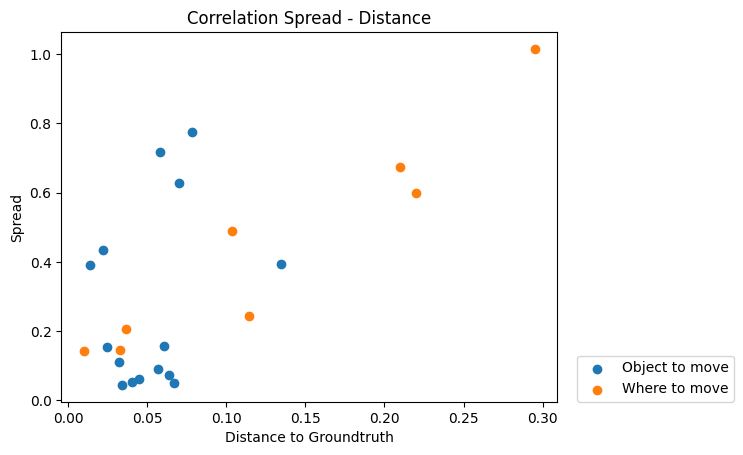

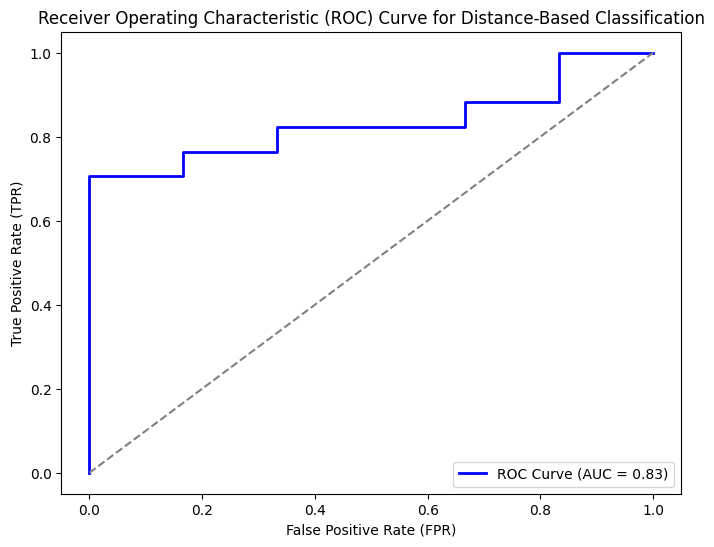

[        inf  0.95527864  0.79257773  0.75574971  0.60962508  0.60624449
  0.56439367  0.40078718  0.37168161  0.32741692  0.22447095 -0.01499163]
0.7925777254005733


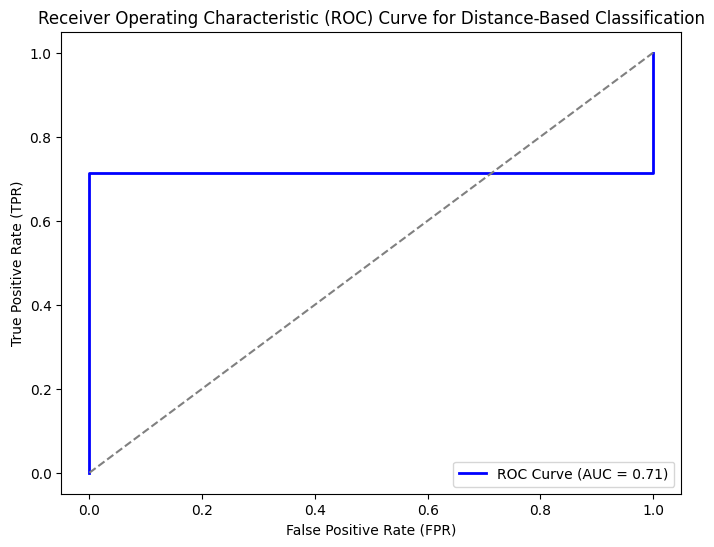

[       inf 0.95527864 0.60962508 0.60624449 0.22447095]


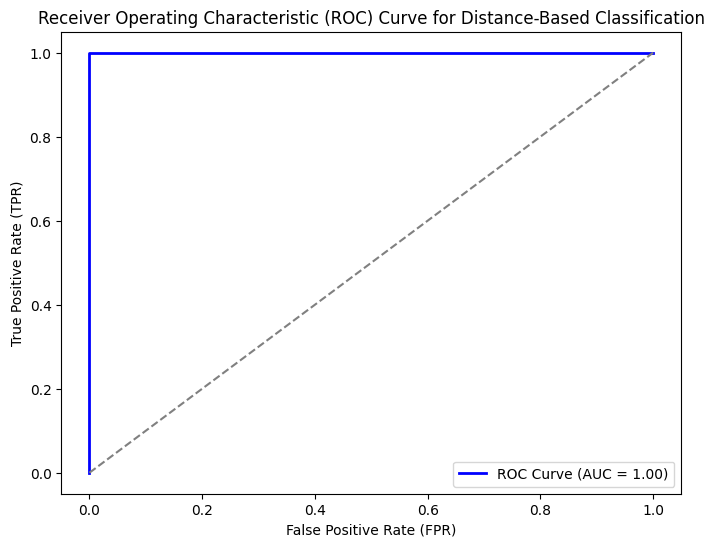

[        inf  0.85826824  0.79257773 -0.01499163]


In [20]:
plot_scatter(["Object to move", "Where to move"], spreads, distances, "Correlation Spread - Distance", "Distance to Groundtruth", "Spread")
#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, spreads[0])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, spreads[1])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

spreads_0 = [1 - spread for spread in spreads[0]]
spreads_1 = [1 - spread for spread in spreads[1]]
fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, spreads_0 + spreads_1)
plot_roc_curve(fpr, tpr, roc_auc)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(thresholds[best_idx])

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, spreads_0)
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, spreads_1)
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)


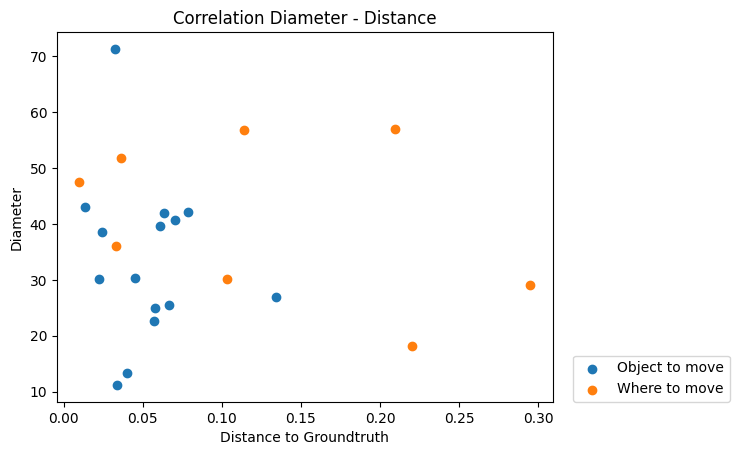

[[0.20736414 0.07169623 0.22602174 0.14459577 0.13732287 0.22595785
  0.21292964 0.16157364 0.1626425  0.06008157 0.21881574 0.12183382
  0.23082587 0.38339389 0.13434648 0.09732473 0.16166298 0.15584192
  0.25490453 0.30630998 0.27866453 0.30555483 0.19412951]]


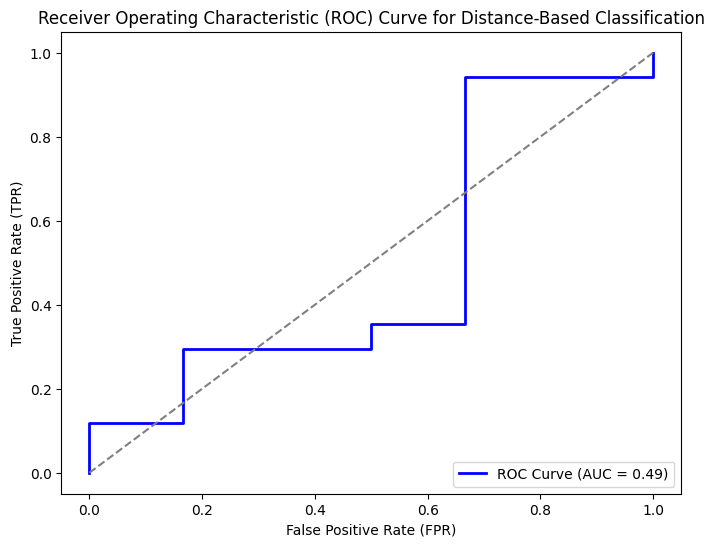

[       inf 0.93991843 0.92830377 0.90267527 0.86267713 0.84415808
 0.83842636 0.83833702 0.72133547 0.69369002 0.61660611]


In [21]:
from sklearn import preprocessing
plot_scatter(["Object to move", "Where to move"], diameters, distances, "Correlation Diameter - Distance", "Distance to Groundtruth", "Diameter")
#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, spreads[0])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, spreads[1])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

dias = preprocessing.normalize([diameters[0] + diameters[1]])
print(dias)
dias = [1 - diameter for diameter in dias[0]]

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, dias)
plot_roc_curve(fpr, tpr, roc_auc)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
print(1 - thresholds[best_idx])

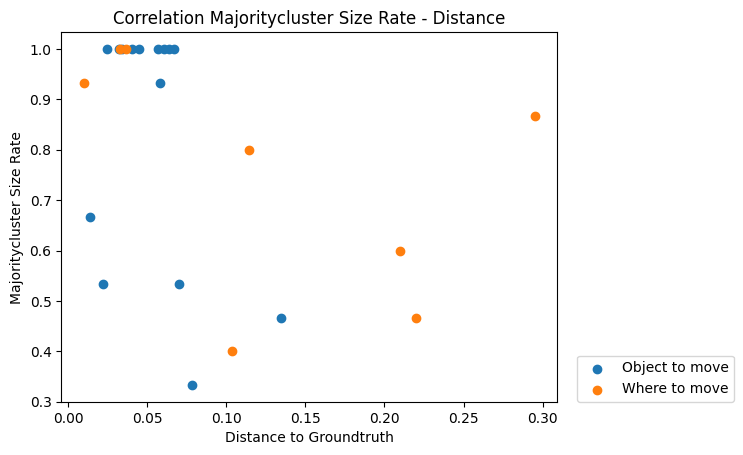

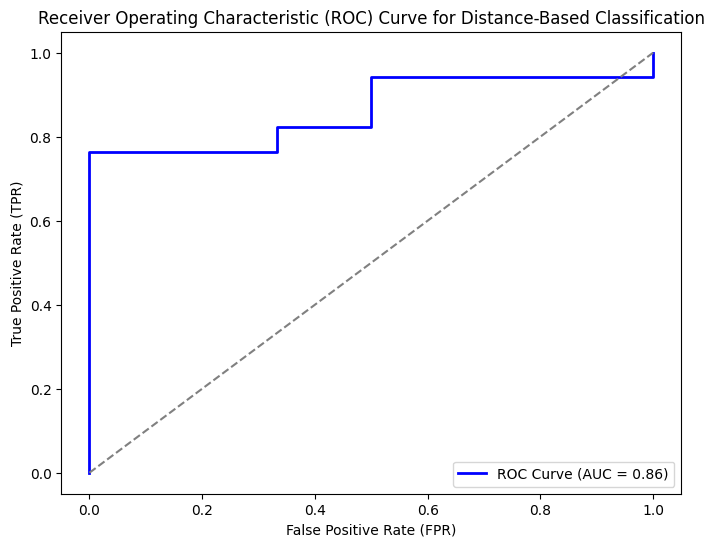

[       inf 1.         0.93333333 0.8        0.66666667 0.6
 0.53333333 0.46666667 0.4        0.33333333]


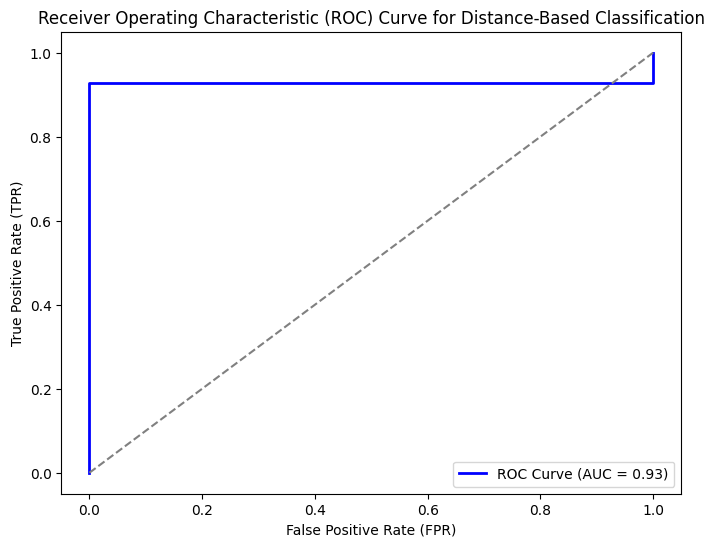

[       inf 1.         0.66666667 0.53333333 0.46666667 0.33333333]


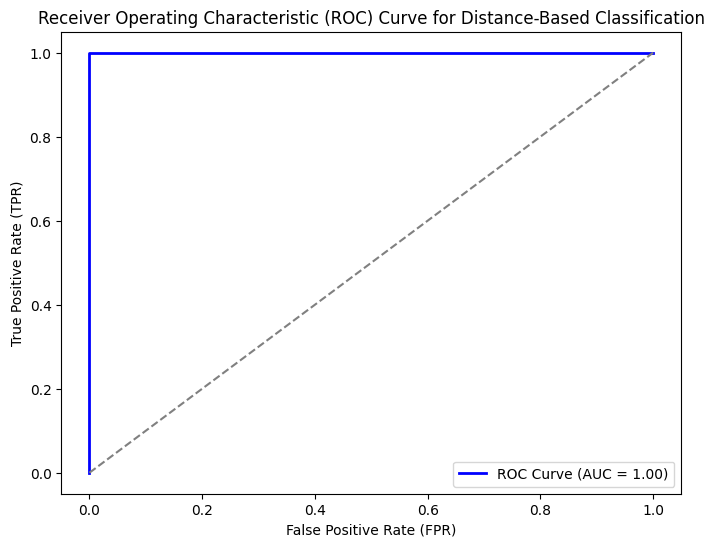

[       inf 1.         0.93333333 0.4       ]


In [22]:
plot_scatter(["Object to move", "Where to move"], majority_size_rates, distances, "Correlation Majoritycluster Size Rate - Distance", "Distance to Groundtruth", "Majoritycluster Size Rate")
#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, spreads[0])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, spreads[1])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, majority_size_rates[0] + majority_size_rates[1])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, majority_size_rates[0])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, majority_size_rates[1])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

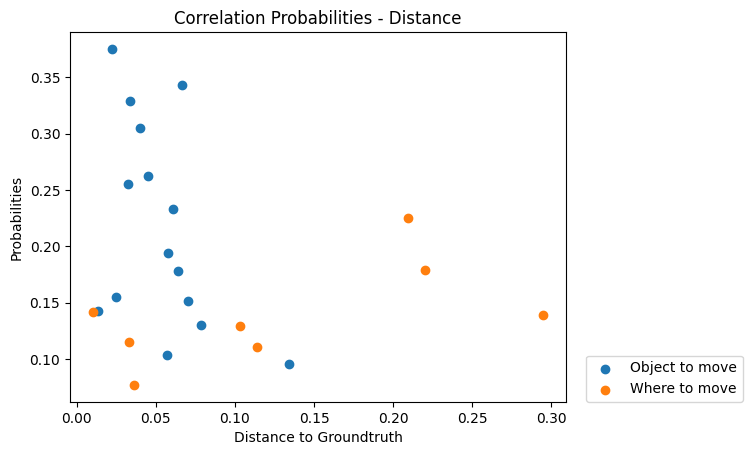

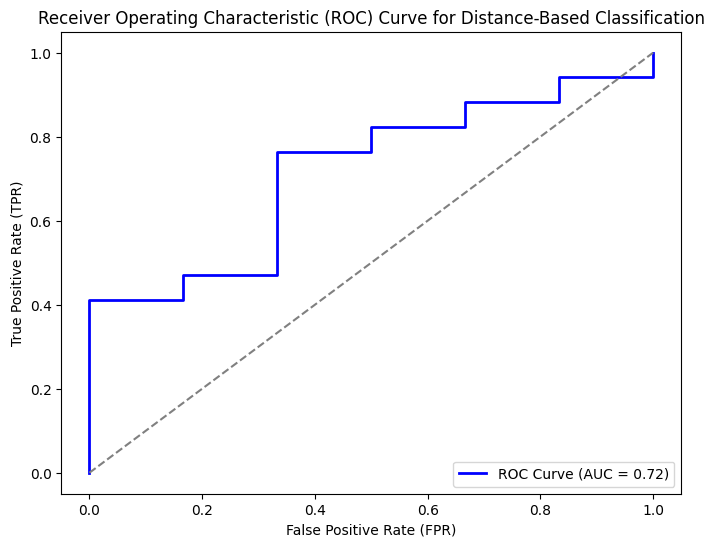

[       inf 0.37530794 0.23318236 0.22483684 0.19393672 0.17942105
 0.14223295 0.13873605 0.13001176 0.12957803 0.11554286 0.11074029
 0.10379378 0.09557408 0.07706402]


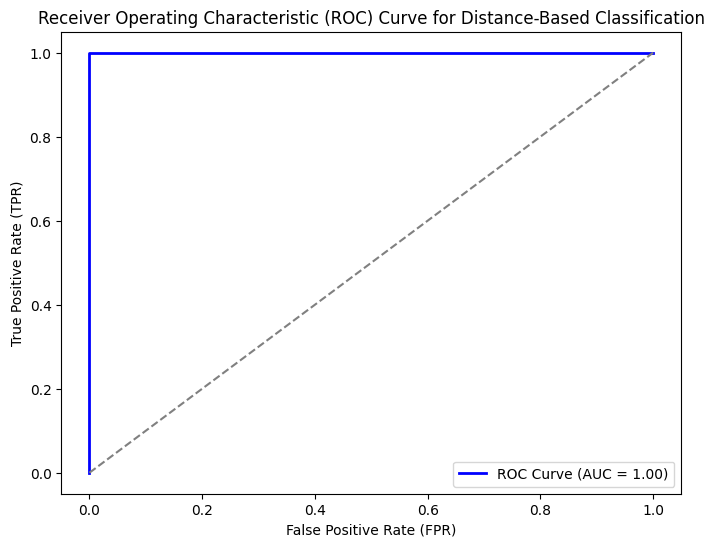

[       inf 0.37530794 0.10379378 0.09557408]


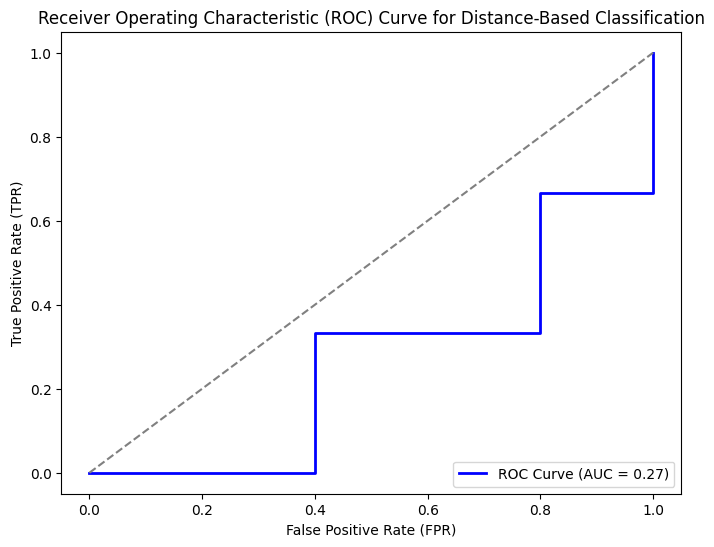

[       inf 0.22483684 0.17942105 0.14223295 0.12957803 0.11554286
 0.11074029 0.07706402]


In [23]:
plot_scatter(["Object to move", "Where to move"], probs, distances, "Correlation Probabilities - Distance", "Distance to Groundtruth", "Probabilities")
#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, spreads[0])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

#fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, spreads[1])
#plot_roc_curve(fpr, tpr, roc_auc)
#print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0] + distances[1], 0.1, probs[0] + probs[1])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[0], 0.1, probs[0])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)

fpr, tpr, roc_auc, thresholds = calculate_roc_curve(distances[1], 0.1, probs[1])
plot_roc_curve(fpr, tpr, roc_auc)
print(thresholds)